In [1]:
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, SimpleRNN, Dropout, Bidirectional
from keras.preprocessing.text import Tokenizer, tokenizer_from_json
from keras.callbacks import EarlyStopping
from keras.models import Sequential
import keras.utils as ku 
import string, os, random, re
from base64 import urlsafe_b64encode as b64
import tensorflow as tf
import pandas as pd
import numpy as np
# from keras import utils as np_utils
from tqdm import tqdm # pip3 install tqdm
import enchant # pip3 install pyenchant
import matplotlib.pyplot as plt

In [2]:
DATA_SUBSET = "Artist_Bob Marley" # "60_en_US" # or "Artist_Bob Dylan"
LYRICS_LIMIT = 200 # 0 for no limit, don't use negative numbers
ENDL_AS_TOKEN = True # False not supported
REMOVE_TAGS = True
N_GRAMS_LINES = 4 # 0 for circular: TODO
DROP_DUPLICATES = True
REMOVE_EMPTY_ROWS = False
REMOVE_DOUBLE_EMPTY_ROWS = True
ARCHITECTURES = ["SimpleLSTM", "SimpleRNN", "BiLSTM"]
BLACKLIST = () # ("fuc", "bitc", "nigg")

# dataset config string, used to differentiate stored models
# and traning histories
# TODO: Low priority -- remove separator between booleans
CONFIG = '_-_'.join([
    str(it) if type(it) is not bool else ('1' if it else '0')
    for it in
    [DATA_SUBSET, LYRICS_LIMIT, ENDL_AS_TOKEN, REMOVE_TAGS, N_GRAMS_LINES,
    DROP_DUPLICATES, REMOVE_EMPTY_ROWS, REMOVE_DOUBLE_EMPTY_ROWS,
    b64(hash(BLACKLIST).to_bytes(8, "little")).decode("ascii") if BLACKLIST else ""]
])

histories = {}
models = {}

for dirname in ("models", "tokenizers", "histories"):
    if not os.path.isdir(dirname):
        os.mkdir(dirname)

# get a string describing dataset and/or other parameters
# needed for storing and loading training results and tokenizers
def get_fn(what_for, architecture=None, epoch=None, config=CONFIG):
    what_for = what_for.lower()
    if what_for.startswith('t'): # tokenizer
        return os.path.join("tokenizers", config + ".json")
    elif what_for.startswith('m'): # model
        assert architecture is not None and epoch is not None
        return os.path.join("models",
                            "_-_".join((str(epoch), architecture, config)))
    elif what_for.startswith('h'): # history
        assert architecture is not None
        return os.path.join("histories",
                            "_-_".join((architecture, config)) + ".csv")
        
print(get_fn('m', ARCHITECTURES[0], 80))

tokenizers\Artist_Bob Marley_-_200_-_1_-_1_-_4_-_1_-_0_-_1_-_.json


In [3]:
def get_lyrics(songs, artist, title=None):
    if title is None: return songs[(songs.artist == artist)]
    return songs[(songs.artist == artist) & (songs.title == title)]

def is_correct_language(lyrics, enchant_dict, retain_rate):
    ws = keras.preprocessing.text.text_to_word_sequence(lyrics)
    return sum(map(enchant_dict.check, ws)) >= retain_rate * len(ws)

def contains_bad_words(lyrics, blacklist):
    for blacklisted in blacklist:
        if blacklisted in lyrics:
            print("Blacklisted")
            return True
    return False

In [4]:
songs = pd.read_csv('./datasets/labeled_lyrics_cleaned.csv',
                    usecols=["artist", "seq", "song"])
songs.rename(columns={"seq": "lyrics", "song": "title"}, inplace=True)
songs.dropna(inplace=True)
if REMOVE_TAGS:
    songs.lyrics = songs.lyrics.str.strip().replace(re.compile(r"\r|(\[[^\n\]]*])"), '')
else:
    songs.lyrics = songs.lyrics.str.strip().replace('\r', '')
if REMOVE_EMPTY_ROWS:
    songs.lyrics = songs.lyrics.str.replace(re.compile(r"\n+"), '\n')
if REMOVE_DOUBLE_EMPTY_ROWS and not REMOVE_EMPTY_ROWS:
    songs.lyrics = songs.lyrics.str.replace(re.compile(r"\n\n+"), '\n\n')
if ENDL_AS_TOKEN:
    songs.lyrics = songs.lyrics.str.replace('\n', ' endl\n') + ' endl'
if DROP_DUPLICATES:
    songs.drop_duplicates(subset="lyrics", inplace=True, ignore_index=True)
all_lyrics = []
if DATA_SUBSET.startswith("Artist_"):
    artists_songs = get_lyrics(songs, DATA_SUBSET[7:])
    if LYRICS_LIMIT:
        all_lyrics = list(artists_songs.lyrics.iloc[:LYRICS_LIMIT])
    else:
        all_lyrics = list(artists_songs.lyrics)
else:
    song_iterator = songs.iterrows()
    language = DATA_SUBSET[DATA_SUBSET.index('_') + 1:]
    percentage = int(DATA_SUBSET[:DATA_SUBSET.index('_')]) * 0.01
    d = enchant.Dict(language)
    for i in tqdm(range(LYRICS_LIMIT or len(songs))):
        index, song = next(song_iterator)
        while (not(is_correct_language(song.lyrics, d, percentage))
               or contains_bad_words(song, BLACKLIST)):
            index, song = next(song_iterator)
        all_lyrics.append(song.lyrics)

lyrics_cnt = len(all_lyrics)
print(lyrics_cnt)

In [6]:
def get_sequence_of_tokens(corpus, tokenizer, lines_in_n_gram=2):
    input_sequences = []
    for song in tqdm(corpus):
        token_lists = tokenizer.texts_to_sequences(song.split('\n'))
        for i in range(lines_in_n_gram, len(token_lists)):
            flat = [jt for it in token_lists[i-lines_in_n_gram:i] for jt in it]
            for j in range(1, len(flat)):
                n_gram_sequence = flat[:j+1]
                input_sequences.append(n_gram_sequence)
    return input_sequences

def get_padded_sequences(input_sequences):
    max_seq_len = max([len(x) for x in input_sequences])
    padded_input_sequences = np.array(pad_sequences(input_sequences, 
                                                     maxlen=max_seq_len,
                                                     padding='pre'))
    return padded_input_sequences, max_seq_len


def prep_train_data(padded_input_sequences, total_words):
    
    x_train = padded_input_sequences[:,:-1]
    labels = padded_input_sequences[:,-1]
    labels = keras.utils.np_utils.to_categorical(labels, num_classes=total_words)
    
    return x_train, labels

In [7]:
tokenizer_fn = get_fn("tokenizer")
if os.path.isfile(tokenizer_fn):
    with open(tokenizer_fn, 'r', encoding="utf-8") as inf:
        tokenizer = tokenizer_from_json(inf.read())
else:
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(all_lyrics)
    with open(tokenizer_fn, 'w', encoding="utf-8") as outf:
        outf.write(tokenizer.to_json())
total_words = len(tokenizer.word_index) + 1
input_sequences = get_sequence_of_tokens(all_lyrics, tokenizer, 4)
padded_input_sequences, max_seq_len = get_padded_sequences(input_sequences)
x_train, labels = prep_train_data(padded_input_sequences,total_words)

100%|███████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 631.15it/s]


In [8]:
# print('\n'.join(sorted(tokenizer.word_index)), end="\n\n\n")
# print('\n'.join(tokenizer.sequences_to_texts(input_sequences[:20])))
print(max_seq_len)

64


In [9]:
def build_model(architecture, max_seq_len, total_words):
    
    input_len = max_seq_len - 1 #zadnju predvidam
    model = Sequential()
    
    # Add Input Embedding Layer
    model.add(Embedding(total_words, 10, input_length=input_len))
    
    if architecture == "SimpleLSTM":
        # Add Hidden Layer 1 - LSTM Layer
        model.add(LSTM(128))
        model.add(Dropout(0.1))
    elif architecture == "SimpleRNN":
        model.add(SimpleRNN(128))
    elif architecture == "BiLSTM":
        model.add(Bidirectional(LSTM(150, return_sequences=True)))  # A dropout layer for regularisation
        model.add(Dropout(0.2))# Add another LSTM Layer
        model.add(LSTM(100))
        model.add(Dense(total_words/2, activation='relu'))

    # In the last layer, the shape should be equal to the total number of words present in our corpus
    # Add Output Layer
    model.add(Dense(total_words, activation='softmax'))

    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics="accuracy")
    
    return model

class StoreModelCallback(keras.callbacks.Callback):
    MILESTONE_EPOCHS = (1, 20, 50, 80, 110)
    def __init__(self, architecture):
        super(StoreModelCallback, self).__init__()
        self.architecture = architecture
    def on_epoch_end(self, epoch, logs=None):
        if epoch in map(lambda x: x-1, StoreModelCallback.MILESTONE_EPOCHS):
            self.model.save(get_fn('m', self.architecture, epoch + 1))
        

# model = keras.models.load_model("80_-_SimpleLSTM_-_" + CONFIG)

In [12]:
def train_model(x_train, labels, architecture, target_epoch, models, histories):
    me = StoreModelCallback.MILESTONE_EPOCHS
    key = get_fn('m', architecture, target_epoch)
    
    # try to find a last pretrained model in the models folder
    last_stored_epoch = 0
    for fn in filter(lambda x: CONFIG in x, os.listdir("models")):
        epoch = max(int(fn.split("_-_")[0]), last_stored_epoch)
        last_stored_epoch = min(epoch, target_epoch)
    if last_stored_epoch == 0: # if there are no such models, build a new one
        models[key] = build_model(architecture, max_seq_len, total_words)
    else: # otherwise load the model
        models[key] = keras.models.load_model(
            get_fn('m', architecture, last_stored_epoch))
    if last_stored_epoch == target_epoch:
        return
    res = models[key].fit(x_train, labels, epochs=target_epoch, verbose=1,
                          callbacks=[StoreModelCallback(architecture)],
                          initial_epoch=last_stored_epoch)
    store_history(res, get_fn('h', architecture), histories)

In [13]:
models = models or {}
histories = histories or {}

architecture = "SimpleLSTM"
epochs = 80

train_model(x_train, labels, architecture, epochs, models, histories)

model = models[get_fn('m', architecture, epochs)]

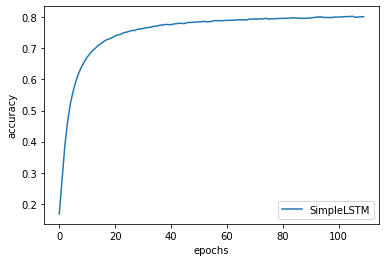

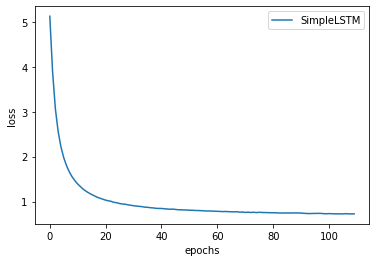

In [20]:
def store_history(history_callback, fn, histories):
    df = pd.DataFrame(history_callback.history)
    if fn in histories:
        histories[fn] = df.merge(histories[fn], how="left")
    elif os.path.isfile(fn):
        df2 = pd.read_csv(fn, index_col=0)
        histories[fn] = df.merge(df2, how="left")
    else:
        histories[fn] = df
    histories[fn].to_csv(fn)
    
def get_history(histories, fn):
    if fn not in histories:
        histories[fn] = pd.read_csv(fn, index_col=0)
    return histories[fn]

def plot_history(histories, architectures=None):
    accuracies = []
    losses = []
    plt.figure()
    if architectures is None:
        architectures = list(histories)
    for it in architectures:
        history = get_history(histories, get_fn('h', it))
        plt.plot(history.index, history.accuracy, label=it)
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.legend()
    plt.show()
    plt.figure()
    for it in architectures:
        history = get_history(histories, get_fn('h', it))
        plt.plot(history.index, history.loss, label=it)
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend()
    plt.show()
try:
    plot_history(histories, [architecture])
except FileNotFoundError:
    print("One of the architectures provided hasn't been trained yet.")


In [18]:


def generate_lyrics_endl_as_token(seed_txt,
                                  lines_in_n_gram,
                                  num_lines,
                                  max_line_len,
                                  max_seq_len,
                                  model,
                                  no_anaphora=False,
                                  keep_seed=False):
    # cleaning the seed text, adding endl and splitting into lines
    st_list = (seed_txt.strip().replace('\r', "").replace('\n', " endl\n")
               + " endl").split('\n')
    # keep at most last lines_in_gram lines
    st_list = st_list[max(0, len(st_list) - lines_in_n_gram):]
    # seed text to tokens (list of tokens for each line)
    token_list = tokenizer.texts_to_sequences(st_list)
    if len(token_list) < lines_in_n_gram - 1:
        pass
    # how many lines do we need
    lines_remaining = num_lines - (len(token_list) if keep_seed else 0)
    # flatten all the tokens into single list
    flat = [jt for it in token_list for jt in it]
    endl_token = tokenizer.word_index["endl"]
    tokenized_song = []
    curr_line = []
    while lines_remaining:
        # print(lines_remaining)
        if len(curr_line) >= max_line_len:
            prediction = endl_token
        else:
            padded_token_list = pad_sequences([flat], maxlen=max_seq_len-1, padding='pre')
            predictions = model.predict(padded_token_list)
            # print(type(predictions))
            if (no_anaphora): # can be changed to first word only
                for prev_line in token_list:
                    if (len(curr_line) < len(prev_line)
                        and curr_line == prev_line[:len(curr_line)]):
                        # print(curr_line)
                        word_in_prev_line = prev_line[len(curr_line)]
                        # print(word_in_prev_line)
                        predictions[0][word_in_prev_line] = np.min(predictions, axis=-1)
            prediction = np.argmax(predictions, axis=-1)[0]
        curr_line.append(prediction)
        flat.append(prediction)
        if prediction == endl_token:
            lines_remaining -= 1
            if len(token_list) >= lines_in_n_gram: del token_list[0]
            token_list.append(curr_line)
            tokenized_song.append(curr_line[:-1])
            curr_line = []
            flat = [jt for it in token_list for jt in it]
    # print(tokenized_song[1:])
    print('\n'.join(
        tokenizer.sequences_to_texts(tokenized_song)
    ))

In [19]:

# duljina pjesme iz iste distribucije kao ostale
num_lines = random.choice([it.count("\n") for it in all_lyrics])
max_line_len = max([max([len(it.split()) for it in song.split("\n")]) for song in all_lyrics])


seed_txt = """Here's a little song I wrote
You might want to sing it note for note
Don't worry, be happy"""

# seed_txt = ""

generate_lyrics_endl_as_token(seed_txt,
                              lines_in_n_gram=4,
                              num_lines=num_lines,
                              max_line_len=max_line_len,
                              max_seq_len=max_seq_len,
                              model=model,
                              no_anaphora=True)


we'll be forever loving jah
oh oh oh oh oh oh oh
open country

say we gonna rock it baby rock it baby
tonight
rock it baby rock it baby tonight
we gonna rock it baby wo rock it baby tonight

baby we've got a date don't you remember
gonna rock it baby rock it baby tonight
got to get together babe tonight
say we got to get together babe tonight

oh baby baby baby just just just too cok cok at i
if you see me cryin'
said i'm given my love to you baby
you've got my love you've got my love

whoo i'm never gonna give my love to nobody but you baby but you baby
never gonna give my love to nobody but you baby but you baby
i mean you what i know
love that i will be my people
you can't the heart i can't resist
where i can tell the children
in the abundance of water
the fool is thirsty
are you satisfied with the one drop
and the world that the builder refuse
shall be the head cornerstone
you can't fool the youths

no matter what you don't
'cause we're coming in from the cold
we're coming in we're